<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Exploring additional tonyear approaches implemented by the Climate Action Reserve and the government of Quebec

_by Freya Chay (CarbonPlan)_

This notebook introduces our implementation of the ton-year methods used by the Climate Action
Reserve (CAR) and proposed by the government of Quebec (QC).

We also compare the replicated methods to the implementation of the Lashof method in the `tonyear`
package.

Sources:

- [Climate Action Reserve Soil Enrichment Protocol (2020)](https://www.climateactionreserve.org/wp-content/uploads/2020/10/Soil-Enrichment-Protocol-V1.0.pdf)
- [Quebecois draft ton-year methodology (2021)](https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/quebec-protocole-foret-en.pdf)


In [1]:
%load_ext watermark
%matplotlib inline

import math

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/tonyear')
import tonyear

from carbonplan import styles
styles.mpl.set_theme(style='carbonplan_light', font_scale=1.25)

In [2]:
%watermark -u -i -v -m -g -iv

Last updated: 2022-02-09T01:43:06.684241+00:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.10.2

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.129+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 6ae55c811faf5bf1664026dd2cc800a3a88c73f7

tonyear   : 1.0.0
matplotlib: 3.4.3
numpy     : 1.20.3
sys       : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
carbonplan: 0.4.0



In [3]:
def get_discounted_curve(discount_rate: float, curve: np.ndarray) -> np.ndarray:
    """Get discounted curve

    Parameters
    ----------
    discount_rate : float
        Discount rate expressed as a fraction.
    curve : np.ndarray

    Returns
    -------
    discounted_curve : np.ndarray
        Curve with discount rate applied.
    """
    return curve / np.power(1 + discount_rate, np.arange(len(curve)))

In [4]:
def calculate_tonyears(
    method: str, baseline: np.ndarray, time_horizon: int, delay: int, discount_rate: float
) -> dict:
    """This function calculates the benefit of a delayed emission according one
    of two ton-year accounting methods.

    Parameters
    ----------
    method : str
        The ton-year accounting method (Moura Costa: 'mc', or Lashof: 'lashof')
    baseline : np.ndarray
        Array modeling the residence of an emission in the atmosphere over time, i.e. a decay
        curve / impulse response function
    time_horizon : int
        Specifies the period over which the impact of an emission is considered (years)
    delay : int
        Specifies the emission delay for which a ton-year benefit will be calculated (years)
    discount_rate : float
        Specifies the discount rate to apply time preference to both costs and benefits over the
        time horizon. Extreme caution should be used when applying discounting within ton-year
        accounting. See documentation for more details.

    Returns
    -------
    method_dict : dict
        Return dict with the following keys:

        - `parameters` : key parameters used for the calculation
        - `baseline` : array modeling baseline emission curve, discounted if applicable
        - `scenario` : array modeling the scenario curve, discounted if applicable
        - `baseline_atm_cost` : the cost of of a baseline emission
        - `benefit` : the benefit of delaying an emission, calculated according to
          specified accounting method
        - `num_for_equivalence` : the ratio between the baseline cost and the benefit

    """

    if delay < 0:
        raise ValueError("Delay cannot be negative.")
    if time_horizon <= 0:
        raise ValueError("Time horizon must be greater than zero.")
    if len(baseline) < time_horizon:
        raise ValueError("Time horizon cannot be longer than length of the baseline array.")

    # All methods calculate the baseline cost of emitting 1tCO2 at t=0 as the
    # atmospheric ton-years incurred over the period 0<=t<=time_horizon.
    time_horizon_timesteps = time_horizon + 1
    baseline = baseline[:time_horizon_timesteps]
    baseline_discounted = get_discounted_curve(discount_rate, baseline)
    baseline_atm_cost = np.trapz(baseline_discounted)

    if method == "mc":
        # The Moura-Costa method calculates the ton-year benefit of a delayed emission
        # as the ton-years of carbon storage outside of the atmosphere over the period
        # 0<=t<=delay. Moura-Costa ignores the atmospheric impact of post-storage re-emission.
        delay_timesteps = delay + 1
        scenario = np.concatenate(
            (np.full(delay_timesteps, -1), np.zeros(len(baseline) - delay_timesteps))
        )
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = -np.trapz(scenario[:delay_timesteps])

    elif method == "lashof":
        # The Lashof method calculates calculates the ton-year benefit of an emission at t=delay
        # as the atmospheric cost that no longer occurs within the time horizon. This can also
        # be understood as the difference between the baseline atmospheric cost and the scenario
        # atmospheric cost, calculated over the period delay<=t<=time_horizon.
        scenario = np.concatenate((np.zeros(delay), baseline))[:time_horizon_timesteps]
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = baseline_atm_cost - np.trapz(scenario[delay:])

    elif method == "car":
        scenario = np.concatenate((np.zeros(delay), baseline))[:time_horizon_timesteps]
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = (1 / time_horizon) * baseline_atm_cost * delay

    elif method == "qc":
        scenario = np.concatenate((np.zeros(delay), baseline))[:time_horizon_timesteps]
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = np.trapz(baseline[: delay + 1])

    else:
        raise ValueError(f"No ton-year accounting method called {method}")

    return {
        "parameters": {
            "method": method,
            "time_horizon": time_horizon,
            "delay": delay,
            "discount_rate": discount_rate,
        },
        "baseline": baseline_discounted,
        "scenario": scenario,
        "baseline_atm_cost": baseline_atm_cost,
        "benefit": benefit,
        "num_for_equivalence": baseline_atm_cost / benefit,
    }

## Comparing the CAR and Quebecois methods to Lashof


If you aren't familiar with the Lashof method or the concept of an 'equivalence ratio', please take
a minute to check out our
[ton-year explainer article](https://carbonplan.org/research/ton-year-explainer). In brief, the
equivalence ratio describes how many tons of CO₂ need to be temporarily stored to justify an
additional ton of CO₂ emitted to the atmosphere today under a given set of assumptions.

The Lashof method calculates the benefit of temporary carbon storage by asking how many ton-years of
atmospheric impact are avoided as a result of the carbon storage. To do so, the Lashof method looks
looks both at the ton-year benefit of the carbon storage and at the ton-year cost of re-emission
after the storage period ends.

Neither the CAR nor Quebecois methods explicitly consider the ton-year cost of re-emission. We can
compare the equivalence ratios generated by these methods to the equivalence ratios generated by the
Lashof method get a sense of how much temporary carbon storage might be overvalued as a result.

Both the CAR and Quebecois methods are explored in more detail below.


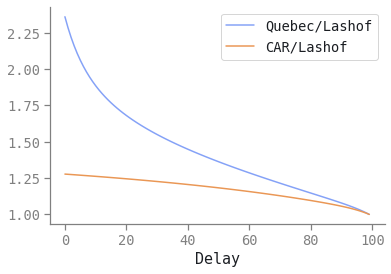

In [6]:
curve = tonyear.get_baseline_curve("joos_2013")
delays = np.arange(1, 101)
time_horizon = 100
discount_rate = 0

equivalence_lashof = [
    1
    / tonyear.calculate_tonyears("lashof", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]
equivalence_car = [
    1 / calculate_tonyears("car", curve, time_horizon, delay, discount_rate)["num_for_equivalence"]
    for delay in delays
]
equivalence_qc = [
    1 / calculate_tonyears("qc", curve, time_horizon, delay, discount_rate)["num_for_equivalence"]
    for delay in delays
]

plt.plot(np.array(equivalence_qc) / np.array(equivalence_lashof), label="Quebec/Lashof")
plt.plot(np.array(equivalence_car) / np.array(equivalence_lashof), label="CAR/Lashof")

plt.xlabel("Delay")
plt.legend()
plt.show()

While all three methods converge on 100 years of carbon storage being equivalent to a 1 tCO2
emission, they diverge for shorter storage periods. The Quebecoi method, in particular, overvalues
very temporary storage by ignoring the costs of re-emission. To give a more specific example, we can
compare how tCO2 stored for 1 year each method would require for equivalence.


In [ ]:
print(f"Lashof requires:   {round(1/equivalence_lashof[0])} tCO2 stored for 1 year")
print(f"CAR requires:      {round(1/equivalence_car[0])} tCO2 stored for 1 year")
print(f"Quebec requires:   {round(1/equivalence_qc[0])} tCO2 stored for 1 year")
print()

## The Climate Action Reserve method


The Climate Action Reserve (CAR) ton-year method calculates the benefit of temporary carbon storage
by (1) defining the duration of carbon storage considered equivalent to an emission and (2) awarding
proportional credit linearly over the time horizon for more temporary storage.

CAR specifically defines 100 year storage as "completely mitigat[ing] an equal GHG emission
elsewhere." In other words, CAR claims that storing 1 tCO2 for 100 years (100 ton-years of storage)
is equivalent to a 1 tCO2 emission. Storing 1 tCO2 for 1 years (1 ton-years) would only provide
1/100th of the benefit needed for equivalence. Similarly, storing 1 tCO2 for 20 years (20 ton-years)
would provide 1/5th of the benefit needed for equivalence.

The CAR ton year accounting method is in the Soil Enrichment Protocol (V1) in section 3.5.5:
https://www.climateactionreserve.org/wp-content/uploads/2020/10/Soil-Enrichment-Protocol-V1.0.pdf

We show two examples of the `tonyear` module's calculations below for CAR's method with a 100 year
time horizon.


In [ ]:
time_horizon = 100
discount_rate = 0
delay = 1
baseline = tonyear.get_baseline_curve("joos_2013")

tonyear.print_benefit_report(
    calculate_tonyears("car", baseline, time_horizon, delay, discount_rate)
)

In [ ]:
time_horizon = 100
discount_rate = 0
delay = 30
baseline = tonyear.get_baseline_curve("joos_2013")

tonyear.print_benefit_report(
    calculate_tonyears("car", baseline, time_horizon, delay, discount_rate)
)

In essence, the CAR method awards benefit linearly in proportion to the time_horizon of choice.


## Proposed Quebecois method


The governement of Quebec (specifically the Ministère de l’Environnement et de la Lutte contre les
changements climatiques) has published a draft ton-year accounting method which (as of
February 2022) is
[presented](https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/index-en.htm#developing-regulations-work)
as a work in progress to "allow more offset credit projects to be carried out and to increase the
supply of Québec credits..." The proposed method calculates the benefit of temporary carbon storage
by (1) defining the duration of carbon storage considered equivalent to an emission and (2) awarding
credit over the time horizon in proportion to the shape of the IRF curve.

The Quebecois method is described in a slide deck presenting the draft ton-year accounting approach:
https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/quebec-protocole-foret-en.pdf

We show an example of the `tonyear` module's implementation of Quebecois method below.


In [ ]:
time_horizon = 100
discount_rate = 0
delay = 30
baseline = tonyear.get_baseline_curve("joos_2013")

qc = calculate_tonyears("qc", baseline, time_horizon, delay, discount_rate)
tonyear.print_benefit_report(qc)
percent_credit = round(qc["benefit"] / qc["baseline_atm_cost"], 1)
print(
    f"--> {qc['parameters']['delay']} year delay corresponds to {percent_credit*100}% of a credit"
)
print()

In essence, the Quebecois method awards benefit in proportion to the shape of the IRF curve used to
approximate the radiative forcing effect resulting from a CO2 emission in the atmosphere.


In [ ]:
t = np.arange(qc["parameters"]["time_horizon"] + 1)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 8))

ax[0].fill_between(
    t,
    qc["baseline"],
    color="red",
    alpha=0.2,
    label="ton-year cost of emitting 1tCO2",
)

delay = qc["parameters"]["delay"]
time_horizon = qc["parameters"]["time_horizon"]

ax[1].plot(qc["baseline"], color="red", alpha=0.2)
ax[1].fill_between(
    t,
    qc["baseline"],
    where=(t <= qc["parameters"]["delay"]),
    color="green",
    alpha=0.2,
    label="ton-year benefit temporary storage period",
)

handles = []
labels = []
for ax in fig.axes:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.1))
plt.show()